### Import modules

In [109]:
import networkx as nx

from agents import doubling_agent, local_ts_agent, local_ucb_agent,UCRL2_agent,QL_agent,QL_UCB_Hoeffding
from graph_bandit_helper_tools import return_graph,draw_graph
from core import train_agent

import numpy as np
from functools import partial
from time import time

import pickle as pkl

from matplotlib import pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

SEED = 181731

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
def plotRegrets(allRegrets, titles=None, save_fig=None):
    """
    param allRegrets: list of dictionaries of regrets(samples, time_steps) for various algorithms and runs
    """
    nPlots = len(allRegrets)
    sns.set()
    
    labels = {'greedy': 'Local $\epsilon$-greedy', 'thompson': 'Local TS', 'UCB': 'Local UCB','Q_learning': r'QL-$\epsilon$ greedy',\
              'Our Algorithm':'Our Algorithm','UCRL2':'UCRL2','QL_UCB_H':'QL-UCB-H'}
    styles = {'greedy': 'dashed', 'thompson': 'dashed', 'UCB': 'dashed','Q_learning': 'dotted',\
              'Our Algorithm':'solid','UCRL2':'solid','QL_UCB_H':'dotted'}
    colors = {'greedy': 'b', 'thompson': 'r', 'UCB': 'g','Q_learning': 'r',\
              'Our Algorithm':'k','UCRL2':'g','QL_UCB_H':'b'}
    keys = allRegrets[0].keys()
    

    if nPlots == 1:
        regrets = allRegrets[0]
        for i, key in enumerate(keys):
            regret = regrets[key]
            regret = np.cumsum(regret, axis=1)
            regret = np.mean(regret, axis=0)
            plt.plot([i for i in range(1,len(regret)+1)],regret, c=colors[key], linestyle = styles[key], label=labels[key],\
                    linewidth=3)
        if titles is not None:    
            plt.title(titles[0])
    else:
        fig, axes = plt.subplots(2, 3, figsize=(17,10))
        for j, regrets in enumerate(allRegrets):
            for i, key in enumerate(regrets.keys()):
                regret = regrets[key]
                regret = np.cumsum(regret, axis=1)
                df = pd.DataFrame(np.transpose(regret))
                df.columns = [labels[key] for _ in range(regret.shape[0])]
                if j<3:
                    sns.lineplot(ax = axes[0,j], data=df, ci=None, palette=[colors[key]])
                    axes[0,j].set_title(titles[j])
                else:
                    sns.lineplot(ax = axes[1,j%3], data=df, ci=None, palette=[colors[key]])
                    axes[1,j%3].set_title(titles[j])
    plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.45), fontsize=16)
    plt.xlabel('$t$', fontsize=20)
    plt.ylabel('Expected regret', fontsize=20)
    plt.tick_params(labelsize=20)
    plt.style.use('seaborn-dark-palette')
    if save_fig is not None:
        plt.savefig('Figures/'+save_fig, bbox_inches = 'tight')
    plt.show()

### Define parameters

Define the following parameters:  
$\texttt{T}:$ game length  
$\texttt{n_samples}:$ number of games to run   
$\texttt{episodes}:$ number of episodes; Let this be 1 for now 
$\texttt{n_nodes}:$ number of nodes in graph. 
$\texttt{mu_size}:$ the node means are drawn as $\mu\sim \texttt{mu_size}\times \mathcal{N}(0,1)$   
$\texttt{sigma_size}:$ the node standard deviations are set to $\texttt{sigma_size}$ 
$\texttt{epsilon}:$ exploration parameter (only applicable for Q-learning algorithms)  
$\texttt{epsilon_discount}:$ exploration discount parameter (only applicable for Q-learning algorithms)  
$\texttt{algorithms}:$ the algorithms to run. 


 



# Line graph

Run time for thompson: 1.1840839385986328
Run time for UCB: 0.6840271949768066
Run time for UCRL2: 11.191272258758545
Run time for Our Algorithm: 1.0418260097503662
Run time for Q_learning: 1.4676239490509033
Run time for QL_UCB_H: 4.446638107299805


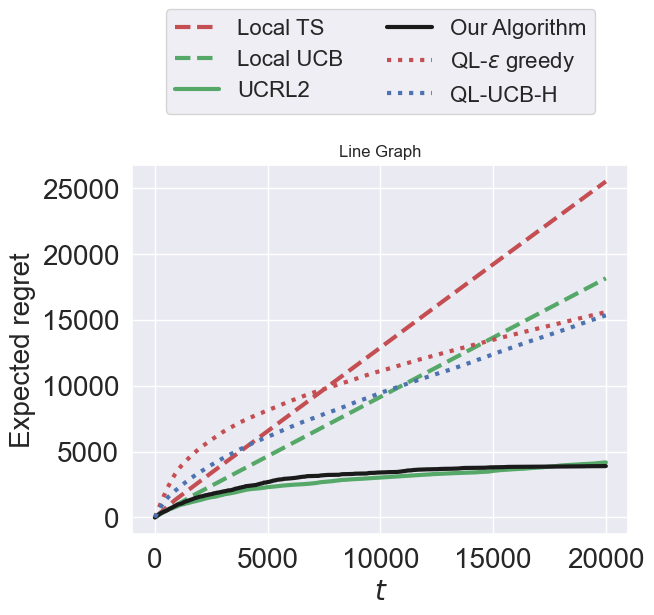

In [108]:
n_samples = 20
episodes = 1
mu_size = 1
sigma_size = 1

init_node = 0

T = 20000

n_nodes = 100
G = return_graph('line', n_nodes)

np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))
# means = np.zeros((n_samples,n_nodes))
# means[:,-1]=0.5
agents = {
    'thompson':partial(local_ts_agent,var=1.0,mu_0=0.0,var_0=1.0),
         'UCB':local_ucb_agent,
         'UCRL2':UCRL2_agent,
         'Our Algorithm':doubling_agent,
        'Q_learning':QL_agent,
        'QL_UCB_H':QL_UCB_Hoeffding
}

line_regrets = {}
for name,agent in agents.items():
    t = time()
    np.random.seed(SEED)
    line_regrets[name] = train_agent(n_samples,T,G,means, init_node,agent,parallelized=True)

    print('Run time for {}:'.format(name),time()-t)


# with open('Data/line_large.pkl', 'wb') as file:
#     pkl.dump(line_regrets,file)

plt.figure(dpi=100)

plotRegrets([line_regrets], titles=['Line Graph'])